## Prediction model

In [40]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
import torch.nn.functional as F

n_component=13

class FNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(n_component,128)
        self.fc2 = nn.Linear(128, 512)
        self.dp1 = nn.Dropout(p=0.3)
        self.fc3 = nn.Linear(512, 256)
        self.dp2 = nn.Dropout(p=0.1)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 32)
        self.fc7 = nn.Linear(32, 16)
        self.fc8 = nn.Linear(16, 1)
        
    def forward(self, x):
        h = F.selu(self.fc1(x)) #best: selu, leaky_relu
        h = F.selu(self.fc2(h))
        h = self.dp1(h)
        h = F.selu(self.fc3(h))
        h = self.dp2(h)
        h = F.selu(self.fc4(h))
        h = F.selu(self.fc5(h))
        h = F.selu(self.fc6(h))
        h = F.selu(self.fc7(h))
        out = self.fc8(h)
        return out

    def fit(self, data_loader, criterion, optimizer):
        self.train()
        sum_train_losses = 0

        for data, target in data_loader:
            
            optimizer.zero_grad()
            pred = self(data)
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()

            sum_train_losses += loss.item()

        return sum_train_losses / len(data_loader)

    def predict(self, data_loader):
        self.eval()
        list_preds = list()

        with torch.no_grad():
            for data, _ in data_loader:
                pred = self(data)
                list_preds.append(pred)

        return torch.cat(list_preds, dim=0).cpu().numpy()

class FNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(n_component,128)
        self.fc2 = nn.Linear(128, 256)
        self.dp1 = nn.Dropout(p=0.3)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 128)
        self.fc5 = nn.Linear(128, 1)
        
    def forward(self, x):
        h = F.selu(self.fc1(x)) #best: selu, leaky_relu
        h = F.selu(self.fc2(h))
        h = self.dp1(h)
        h = F.selu(self.fc3(h))
        h = F.selu(self.fc4(h))
        out = self.fc5(h)
        return out
    
    def fit(self, data_loader, criterion, optimizer):
        self.train()
        sum_train_losses = 0

        for data, target in data_loader:
            
            optimizer.zero_grad()
            pred = self(data)
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()

            sum_train_losses += loss.item()

        return sum_train_losses / len(data_loader)

    def predict(self, data_loader):
        self.eval()
        list_preds = list()

        with torch.no_grad():
            for data, _ in data_loader:
                pred = self(data)
                list_preds.append(pred)

        return torch.cat(list_preds, dim=0).cpu().numpy()

In [41]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [42]:
train_set = pd.read_csv('split/train_split_aug_2nd.csv')
cols = train_set.columns[2:16]
train_set = np.delete(train_set, [0,1], 1).astype(float)
nFeat = len(train_set[0,:]) - 3
X_train = train_set[:,:nFeat]
Y_train_1 = train_set[:,nFeat:nFeat+1]

In [43]:
#VAE from github.com/lschmiddey/Autoencoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [44]:
X_trainAE, X_testAE, Y_trainAE, Y_testAE = train_test_split(train_set, Y_train_1, test_size = 0.25, random_state = 1)
trq = pd.DataFrame(X_trainAE)
tsq = pd.DataFrame(X_testAE)
X_test_fraud = tsq
X_train_fraud = trq

from torch.utils.data import Dataset, DataLoader
class DataBuilder(Dataset):
    def __init__(self, dataset):
        self.x = dataset.values
        self.x = torch.from_numpy(self.x).to(torch.float)
        self.len=self.x.shape[0]
    def __getitem__(self,index):      
        return self.x[index]
    def __len__(self):
        return self.len

In [45]:
traindata_set=DataBuilder(X_train_fraud)
testdata_set=DataBuilder(X_test_fraud)
trainloader=DataLoader(dataset=traindata_set,batch_size=64)
testloader=DataLoader(dataset=testdata_set,batch_size=64)

In [46]:
class Autoencoder(nn.Module):
    def __init__(self,D_in,H=50,H2=12,latent_dim=3):
        #Encoder
        super(Autoencoder,self).__init__()
        self.linear1=nn.Linear(D_in,H)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H)
        self.linear2=nn.Linear(H,H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.linear3=nn.Linear(H2,H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H2)
        # Latent
        self.fc1 = nn.Linear(H2, latent_dim)
        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)
        # Sampling
        self.fc3 = nn.Linear(latent_dim, latent_dim)
        self.fc_bn3 = nn.BatchNorm1d(latent_dim)
        self.fc4 = nn.Linear(latent_dim, H2)
        self.fc_bn4 = nn.BatchNorm1d(H2)
        # Decoder
        self.linear4=nn.Linear(H2,H2)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
        self.linear5=nn.Linear(H2,H)
        self.lin_bn5 = nn.BatchNorm1d(num_features=H)
        self.linear6=nn.Linear(H,D_in)
        self.lin_bn6 = nn.BatchNorm1d(num_features=D_in)
        self.relu = nn.ReLU()
        
    def encode(self, x):
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))
        fc1 = F.relu(self.bn1(self.fc1(lin3)))
        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        return r1, r2
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))
        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
        return self.lin_bn6(self.linear6(lin5))
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
    
    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD

In [48]:
D_in = traindata_set.x.shape[1]
H = 50
H2 = 12
model = Autoencoder(D_in, H, H2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

loss_mse = customLoss()

log_interval = 50
val_losses = []
train_losses = []
test_losses = []

In [51]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    if epoch % 200 == 0:        
        print('====> Epoch: {} Average training loss: {:.4f}'.format(
            epoch, train_loss / len(trainloader.dataset)))
        train_losses.append(train_loss / len(trainloader.dataset))
        
def test(epoch):
    with torch.no_grad():
        test_loss = 0
        for batch_idx, data in enumerate(testloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_mse(recon_batch, data, mu, logvar)
            test_loss += loss.item()
            if epoch % 200 == 0:        
                print('====> Epoch: {} Average test loss: {:.4f}'.format(
                    epoch, test_loss / len(testloader.dataset)))
            test_losses.append(test_loss / len(testloader.dataset))

In [53]:
from torch.autograd import Variable
epochs = 1000
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)

====> Epoch: 200 Average training loss: 101210.3483
====> Epoch: 200 Average test loss: 77808.4500
====> Epoch: 400 Average training loss: 100426.6067
====> Epoch: 400 Average test loss: 77081.2917
====> Epoch: 600 Average training loss: 99653.0702
====> Epoch: 600 Average test loss: 76379.1500
====> Epoch: 800 Average training loss: 98894.5660
====> Epoch: 800 Average test loss: 75715.8500
====> Epoch: 1000 Average training loss: 98159.3413
====> Epoch: 1000 Average test loss: 75055.8833


In [54]:
with torch.no_grad():
    for batch_idx, data in enumerate(testloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)

In [55]:
recon_row = recon_batch[0].cpu().numpy()
recon_row = np.append(recon_row, [1])
real_row = testloader.dataset.x[0].cpu().numpy()
real_row = np.append(real_row, [1])

In [56]:
df_2 = pd.DataFrame(np.stack((recon_row, real_row)))
df_2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,2.625159,1.767482,1.835279,2.173059,1.623488,2.58045,2.061344,2.530609,1.747183,1.828735,3.296142,0.487274,-0.105643,0.48110,1.0
1,8.940000,1.820000,3.270000,2.770000,1.600000,8.19000,2.500000,5.000000,191.899994,1.919700,25.000000,20.120119,17.959200,0.13307,1.0


In [57]:
sigma = torch.exp(logvar/2)
mu.mean(axis=0), sigma.mean(axis=0)
no_samples = 60 #number of fake samples
q = torch.distributions.Normal(mu.mean(axis=0), sigma.mean(axis=0))
z = q.rsample(sample_shape=torch.Size([no_samples]))
with torch.no_grad():
    pred = model.decode(z).cpu().numpy()

In [58]:
df_fake = pd.DataFrame(pred)
df_fake.columns = cols
df_fake.insert(0,'is_synthetic',0)
df_fake.head()

,is_synthetic,l,b1,b5,l_2,b1_2,b5_2,cfbr3,phosphorus,c13,solvent,temp,time_min,e_y,z_y
0,0,2.070625,1.753042,0.903261,2.224044,1.653474,2.245332,1.965322,2.390867,1.847032,1.841948,2.007843,1.250524,1.554446,0.342876
1,0,2.529965,1.861586,3.515599,2.926995,1.692854,2.869402,2.115003,2.622406,3.985671,1.824483,4.678468,-0.388829,-1.078464,0.727821
2,0,5.425063,2.008834,2.525557,2.625635,1.635177,2.889070,2.140375,2.519839,4.314331,1.821677,11.621227,0.986931,-1.146458,2.876153
3,0,2.034413,1.861727,2.349277,2.109982,1.614784,3.613938,2.021889,2.620883,0.826508,1.840366,-1.762416,2.453268,1.161939,1.327907
4,0,2.336133,1.902918,3.983044,3.078278,1.710755,2.843156,2.105524,2.624652,5.144796,1.826619,3.282861,-0.490069,-0.818447,0.416124


In [60]:
df = pd.read_csv('split/train_split_aug_2nd.csv')
df = df.drop(labels=['real_rational','compound name'],axis = 1)
df.insert(0,'is_synthetic',0)
df = pd.concat([df_fake,df])
df.head()
df.shape

(298, 15)

In [61]:
test_set = pd.read_csv('split/test_split.csv')
test_set.insert(0,'is_synthetic',0)

train_set = np.delete(df, [], 1).astype(float)
test_set = np.delete(test_set, [1], 1).astype(float)

nFeat = len(train_set[0,:]) - 2

X_train = train_set[:,:nFeat]
X_test = test_set[:,:nFeat]
Y_train_1 = train_set[:,nFeat:nFeat+1]
Y_test_1 = test_set[:,nFeat:nFeat+1]
Y_train_2 = train_set[:,nFeat+1:nFeat+2]
Y_test_2 = test_set[:,nFeat+1:nFeat+2]

In [62]:
#scaler, w/o time
scalerx = RobustScaler().fit (X_train)
X_train = scalerx.transform(X_train)
X_test  = scalerx.transform(X_test)

model: FNN
R2 score:     0.84		0.84


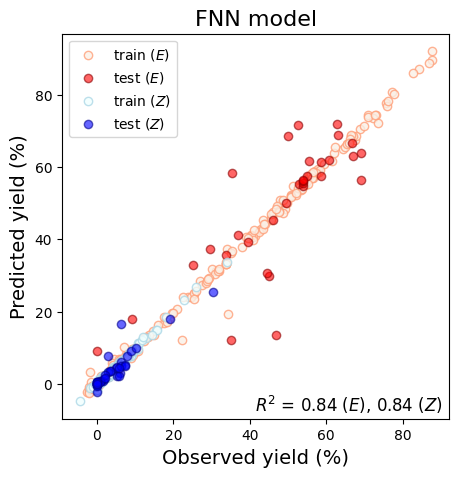

In [71]:
model_1 = {}
model_2 = {}

model_1 = FNN1()
model_2 = FNN2()

print('model: FNN')

random_seed = 5
X_train_1, X_val_1, Y_train_1i, Y_val_1 = train_test_split(X_train, Y_train_1, test_size=0.22, shuffle=True, random_state=random_seed)
X_train_2, X_val_2, Y_train_2i, Y_val_2 = train_test_split(X_train, Y_train_2, test_size=0.22, shuffle=True, random_state=random_seed)

X_train_1t = torch.Tensor(X_train_1)
X_val_1t = torch.Tensor(X_val_1)
X_test_1t = torch.Tensor(X_test)
Y_train_1t = torch.Tensor(Y_train_1i)
Y_val_1t = torch.Tensor(Y_val_1)
Y_test_1t = torch.Tensor(Y_test_1)
X_train_2t = torch.Tensor(X_train_2)
X_val_2t = torch.Tensor(X_val_2)
X_test_2t = torch.Tensor(X_test)
Y_train_2t = torch.Tensor(Y_train_2i)
Y_val_2t = torch.Tensor(Y_val_2)
Y_test_2t = torch.Tensor(Y_test_2)

data_train_1 = TensorDataset(X_train_1t, Y_train_1t)
data_val_1 = TensorDataset(X_val_1t, Y_val_1t)
data_test_1 = TensorDataset(X_test_1t, Y_test_1t)
train_loader_1 = DataLoader(data_train_1, batch_size=64, shuffle=False)
val_loader_1 = DataLoader(data_val_1, batch_size=64, shuffle=False)
test_loader_1 = DataLoader(data_test_1, batch_size=64, shuffle=False)
data_train_2 = TensorDataset(X_train_2t, Y_train_2t)
data_val_2 = TensorDataset(X_val_2t, Y_val_2t)
data_test_2 = TensorDataset(X_test_2t, Y_test_2t)
train_loader_2 = DataLoader(data_train_2, batch_size=64, shuffle=False)
val_loader_2 = DataLoader(data_val_2, batch_size=64, shuffle=False)
test_loader_2 = DataLoader(data_test_2, batch_size=64, shuffle=False)

criterion = nn.MSELoss()
optimizer_1 = optim.Adam(model_1.parameters())
optimizer_2 = optim.Adam(model_2.parameters())

for epoch in range(1000):
    model_1.train()
    train_loss_1 = model_1.fit(train_loader_1, criterion, optimizer_1)
    model_1.eval()
    val_loss_1 = model_1.fit(val_loader_1, criterion, optimizer_1)
for epoch in range(1000):
    model_2.train()
    train_loss_2 = model_2.fit(train_loader_2, criterion, optimizer_2)
    model_1.eval()
    val_loss_2 = model_2.fit(val_loader_2, criterion, optimizer_2)
    
Y_pred_1 = model_1.predict(test_loader_1)
Y_test_1t = Y_test_1t.detach().numpy()
Y_train_out_1 = model_1.predict(train_loader_1)
Y_train_1t = Y_train_1t.detach().numpy()
Y_val_out_1 = model_1.predict(val_loader_1)
Y_val_1t = Y_val_1t.detach().numpy()
r2_yield1 = np.around(r2_score(Y_test_1t,Y_pred_1), 2)
Y_pred_2 = model_2.predict(test_loader_2)
Y_test_2t = Y_test_2t.detach().numpy()
Y_train_out_2 = model_2.predict(train_loader_2)
Y_train_2t = Y_train_2t.detach().numpy()
Y_val_out_2 = model_2.predict(val_loader_2)
Y_val_2t = Y_val_2t.detach().numpy()
r2_yield2 = np.around(r2_score(Y_test_2t,Y_pred_2), 2)

print('R2 score:     {}\t\t{}'.format(r2_yield1, r2_yield2))

plt.rcParams["figure.figsize"] = (5,5)
plt.scatter(Y_train_1t, Y_train_out_1, edgecolors='lightsalmon', facecolors='linen', alpha=0.8, label='train ($\it{E}$)')
plt.scatter(Y_val_1t, Y_val_out_1, edgecolors='lightsalmon', facecolors='linen', alpha=0.8)
plt.scatter(Y_test_1t, Y_pred_1, edgecolors='darkred', facecolors='red', alpha=0.6, label='test ($\it{E}$)')
plt.scatter(Y_train_2t, Y_train_out_2, edgecolors='lightblue', facecolors='azure', alpha=0.8, label='train ($\it{Z}$)')
plt.scatter(Y_val_2t, Y_val_out_2, edgecolors='lightblue', facecolors='azure', alpha=0.8)
plt.scatter(Y_test_2t, Y_pred_2, edgecolors='darkblue', facecolors='blue', alpha=0.6, label='test ($\it{Z}$)')
plt.title('FNN model', fontsize=16)
plt.legend(loc='best')
plt.annotate(r'$R^2$ = {:.2f} '.format(r2_yield1)+'($\mathit{E}$), '+r'{:.2f} '.format(r2_yield2)+'($\mathit{Z}$)', xy=(1,0), xycoords='axes fraction', xytext=(-140, 5), textcoords='offset points', fontsize=12)
plt.xlabel('Observed yield (%)', fontsize=14)
plt.ylabel('Predicted yield (%)', rotation='vertical', fontsize=14)
#plt.show()
plt.savefig("result/aug74thenVAE60_"+str(random_seed)+".png")
np.savetxt("result/aug74thenVAE60_1_"+str(random_seed)+".csv", Y_pred_1, delimiter=",")
np.savetxt("result/aug74thenVAE60_2_"+str(random_seed)+".csv", Y_pred_2, delimiter=",")
torch.save(model_1,"result/aug74thenVAE60_1"+str(random_seed)+".pt")
torch.save(model_2,"result/aug74thenVAE60_2"+str(random_seed)+".pt")